In [215]:
import pandas as pd
import os
from tqdm import tqdm_notebook, tnrange
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import cvxpy as cp
from scipy.sparse import csr_matrix, vstack, hstack

module_path = os.path.abspath(os.path.join('..'))

%matplotlib inline

In [2]:
proteins_df = pd.read_csv(module_path+'/data/harel/protein_df_PD1.csv', index_col=0)

In [3]:
protein_list = list(set(list(proteins_df["Gene_Names"])))

In [5]:
interactome_protein_set = set(np.loadtxt(module_path+
                            '/data/interactome/proteins_in_interactome.txt',
                            dtype=str))

In [6]:
intersection_proteins_to_keep = set()
semicolon_matches = ()
num_nan = 0
for protein in tqdm_notebook(protein_list):
    if protein in interactome_protein_set:
        intersection_proteins_to_keep.add(protein)
    elif len(protein.split(";")) > 1:
        
        if np.sum([x in interactome_protein_set for x in protein.split(";")]) > 1:
            print(protein.split(";"))


In [8]:
with open(module_path+"/data/interactome/inbiomap_reduced.txt", 'w') as g:
    with open (module_path+"/data/interactome/inbiomap.9.12.2016.full.oi2", 'r') as f:
        for line in f:
            line1 = line.split()
            if (line1[0] in intersection_proteins_to_keep
            and line1[1] in intersection_proteins_to_keep):
                g.write(line)

In [9]:
g = nx.read_edgelist(module_path+"/data/interactome/inbiomap_reduced.txt", 
                     data=(('confidence',float),))

In [10]:
nx.write_graphml(g,module_path+"/data/interactome/reduced_interactome.graphml")

In [72]:
intersection_proteins = set(g.nodes())
proteins_not_found = set(protein_list) - intersection_proteins
num_intersection_proteins = len(intersection_proteins)
num_orphan_proteins = len(proteins_not_found)

In [55]:
proteins_df["In_Interactome"] = list(proteins_df["Gene_Names"].isin(list(intersection_proteins)))

In [56]:
protein_new = proteins_df.sort_values(by="In_Interactome", ascending=False).reset_index(drop=True)

In [57]:
protein_number_to_names = list(protein_new["Gene_Names"])
protein_names_to_number = {}

for ind, protein in enumerate(protein_number_to_names):
    protein_names_to_number[protein] = ind

Text(0.5, 0, 'number of neighbours')

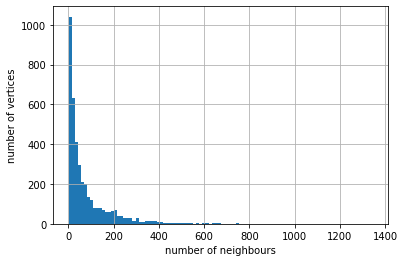

In [44]:
degree_list = list(dict(g.degree()).values())

plt.hist(degree_list, bins = 100)
plt.grid()
plt.ylabel("number of vertices")
plt.xlabel("number of neighbours")

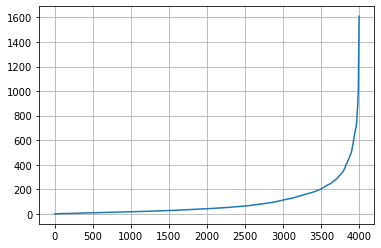

In [63]:
eigenvals = nx.linalg.spectrum.laplacian_spectrum(g, weight="confidence")
plt.plot(eigenvals)
plt.grid()

In [65]:
nodlist = protein_new["Gene_Names"][:num_intersection_proteins]

In [67]:
L = nx.laplacian_matrix(g,nodelist=nodlist, weight="confidence")
U = nx.incidence_matrix(g,nodelist=nodlist, oriented=True, weight="confidence")

In [70]:
L.shape, U.shape

((3995, 3995), (3995, 165392))

In [230]:
Reg0 = np.eye(num_orphan_proteins+num_intersection_proteins)
Reg1 = csr_matrix(scipy.linalg.block_diag(L.todense(),np.eye(num_orphan_proteins)))
temp1 = hstack([U.T, csr_matrix(np.zeros((U.shape[1],num_orphan_proteins)))])
Reg2 = vstack ([temp1, csr_matrix(np.eye(num_intersection_proteins+num_orphan_proteins))])

In [128]:
A = protein_new.to_numpy()[:,:-2].T
alpha=0.1

In [88]:
A.shape

(74, 4249)

In [91]:
response_df = pd.read_csv(module_path+'/data/harel/response_df.csv', index_col=0)

In [158]:
patient_order = proteins_df.columns[:-2]
y_raw = []

for patient in tqdm_notebook(patient_order):
    try:
        pfs = float(response_df[response_df["Sample ID"]==patient]["PFS time (months)"])
    except:
        new_patient = " ".join(patient.split("_"))
        try:
            pfs = float(response_df[response_df["Sample ID"]==new_patient]["PFS time (months)"])
        except:
            print(patient, new_patient)
            raise
        
    y_raw.append(pfs)
yraw = np.array(y_raw).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(yraw)
y = scaler.transform(y.reshape(-1, 1)).reshape(-1)

In [226]:
def lasso1(x):  # following sklearn's definition from user-guide!
    return ((1. / (2*A.shape[0])) * np.square(np.linalg.norm(A.dot(x) - y, 2)) + 
                alpha * np.linalg.norm(Reg0.dot(x), 1))
def lasso2(x):  # following sklearn's definition from user-guide!
    return ((1. / (2*A.shape[0])) * np.square(np.linalg.norm(A.dot(x) - y, 2)) + 
                alpha * np.linalg.norm(Reg1.dot(x), 1))
def lasso3(x):  # following sklearn's definition from user-guide!
    return ((1. / (2*A.shape[0])) * np.square(np.linalg.norm(A.dot(x) - y, 2)) + 
                alpha * np.linalg.norm(Reg2.dot(x), 1))

In [166]:
clf = linear_model.Lasso(alpha=alpha, fit_intercept=False)
clf.fit(A, y)
print(lasso1(clf.coef_), max (clf.coef_))

0.19225107017780615 0.31154256018566084


In [199]:
x = cp.Variable(num_intersection_proteins+num_orphan_proteins)
objective = cp.Minimize((1. / (2*A.shape[0])) * cp.sum_squares(A*x - y)+ alpha* cp.norm1(Reg0*x))
prob = cp.Problem(objective)

In [200]:
result = prob.solve()
print(lasso1(x.value), max (x.value))
vanilla_lasso = x.value

0.19225105031379433 0.31192647669153656


(array([   0,  204,  233,  356,  458,  527,  634, 1308, 1452, 1564, 1714,
        1734, 2007, 2134, 2216, 2275, 2863, 2887, 3073, 3276, 3521, 3572]),)

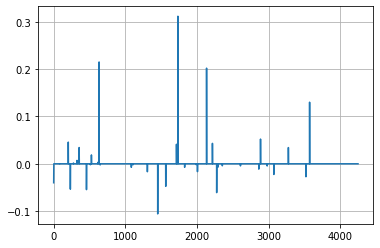

In [201]:
plt.plot(vanilla_lasso)
plt.grid()
np.where(np.abs(vanilla_lasso) > 0.01)

In [173]:
x = cp.Variable(num_intersection_proteins+num_orphan_proteins)
objective = cp.Minimize((1. / (2*A.shape[0])) * cp.sum_squares(A*x - y)+ alpha* cp.norm1(Reg1*x))
prob = cp.Problem(objective)

In [174]:
result = prob.solve()

In [178]:
print(lasso2(x.value), max (x.value))
laplacian_lasso = x.value

0.25729101455182335 0.2329301424341439


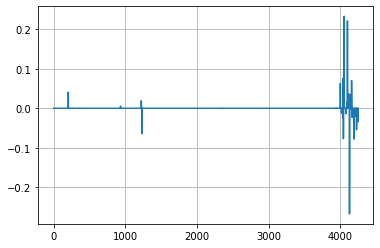

In [182]:
plt.plot(laplacian_lasso)
plt.grid()

In [187]:
np.where(np.abs(laplacian_lasso) > 0.01)

(array([ 204, 1223, 1232, 4001, 4018, 4034, 4036, 4044, 4050, 4055, 4056,
        4079, 4098, 4100, 4119, 4128, 4129, 4147, 4153, 4158, 4166, 4191,
        4192, 4206, 4227, 4246]),)

In [192]:
protein_number_to_names[204], protein_number_to_names[1223], protein_number_to_names[1232]

('POSTN', 'TGFBI', 'TMTC3')

In [193]:
g.degree(["POSTN", 'TGFBI', 'TMTC3'])

DegreeView({'POSTN': 1, 'TGFBI': 1, 'TMTC3': 1})

In [198]:
list(g.neighbors("TMTC3"))

['DVL2']

In [ ]:
x = cp.Variable(num_intersection_proteins+num_orphan_proteins)
alph = cp.Parameter(nonneg=True)
objective = cp.Minimize((1. / (2*A.shape[0])) * cp.sum_squares(A*x - y)+ alph* cp.norm1(Reg1*x))
prob = cp.Problem(objective)
laplacian_lassos = []
alpha_values =  np.logspace(-2, 1, 40)
for v in tqdm_notebook(alpha_values):
    alph.value = v
    prob.solve()
    laplacian_lassos.append(x.value)


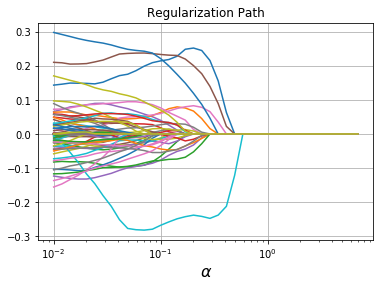

In [260]:
plot_regularization_path(alpha_values[:-2], laplacian_lassos)

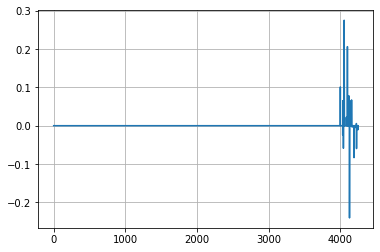

In [267]:
plt.plot(incidence_lassos[10])
plt.grid()

In [266]:
 np.logspace(-2, 1, 40)[10]

0.05878016072274912

In [224]:
x = cp.Variable(num_intersection_proteins+num_orphan_proteins)
objective = cp.Minimize((1. / (2*A.shape[0])) * cp.sum_squares(A*x - y)+ alpha* cp.norm1(Reg2*x))
prob = cp.Problem(objective)

In [225]:
result = prob.solve()

In [227]:
print(lasso3(x.value), max (x.value))
incidence_lasso = x.value

0.25927430557393455 0.2763132466017871


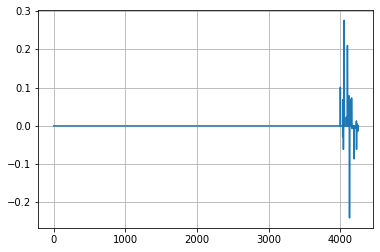

In [229]:
plt.plot(incidence_lasso)
plt.grid()

In [236]:
x = cp.Variable(num_intersection_proteins+num_orphan_proteins)
alph = cp.Parameter(nonneg=True)
objective = cp.Minimize((1. / (2*A.shape[0])) * cp.sum_squares(A*x - y)+ alph* cp.norm1(Reg2*x))
prob = cp.Problem(objective)
incidence_lassos = []
alpha_values = np.logspace(-2, 2, 40)
for v in tqdm_notebook(alpha_values):
    alph.value = v
    prob.solve()
    incidence_lassos.append(x.value)
 

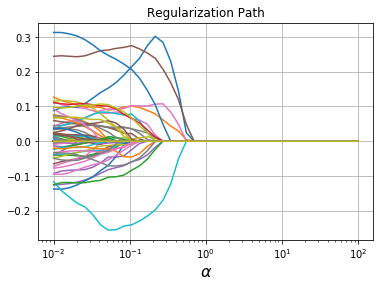

In [240]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\alpha$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.grid()
    plt.show()

plot_regularization_path(alpha_values, incidence_lassos)


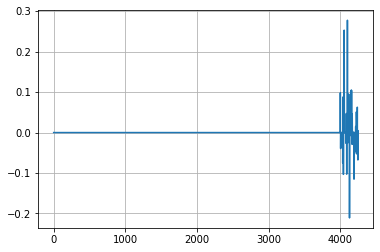

In [252]:
plt.plot(incidence_lassos[5])
plt.grid()